In [1]:
import torch
from torch import nn
#from d2l import torch as d2l
import pandas as pd
import numpy as np
from scipy import sparse
import time

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

/home/artemy/bin/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_dir = '/home/artemy/multimodal_proj/data/competition_toy/'
multi_atac_train_fn = data_dir + "atac_train.sparse.npz"
multi_atac_test_fn = data_dir + "atac_test.sparse.npz"
multi_gex_train_fn = data_dir + "gex_train.sparse.npz"
multi_gex_test_fn = data_dir + "gex_test.sparse.npz"

In [3]:
# https://d2l.ai/_modules/d2l/torch.html
import inspect


class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.
    
        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [4]:
class DataLoaderCOO:
    """Torch compatible DataLoader. Works with in-device TorchCSR tensors.
    Args:
         - train_inputs, train_targets: TorchCSR tensors
         - train_idx: tensor containing the indices of the rows of train_inputs and train_targets that should be used
         - batch_size, shuffle, drop_last: as in torch.utils.data.DataLoader
    """
    def __init__(self, train_inputs, train_targets, train_idx=None, 
                 *,
                batch_size=512, shuffle=False, drop_last=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        
        self.train_inputs = train_inputs
        self.train_targets = train_targets
        self.n_input_features = train_inputs.shape[1]
        self.n_target_features = train_targets.shape[1]
        
        self.train_idx = train_idx
        
        self.nb_examples = len(self.train_idx) if self.train_idx is not None else train_inputs.shape[0]
        
        self.nb_batches = self.nb_examples // batch_size
        if not drop_last and not self.nb_examples%batch_size==0:
            self.nb_batches +=1
        
    def __iter__(self):
        if self.shuffle:
            shuffled_idx = torch.randperm(self.nb_examples, device=device)
            if self.train_idx is not None:
                idx_array = self.train_idx[shuffled_idx]
            else:
                idx_array = shuffled_idx
        else:
            if self.train_idx is not None:
                idx_array = self.train_idx
            else:
                idx_array = None
            
        for i in range(self.nb_batches):
            slc = slice(i*self.batch_size, (i+1)*self.batch_size)
            if idx_array is None:
                inp_batch = self.train_inputs[i*self.batch_size: (i+1)*self.batch_size]
                tgt_batch = self.train_targets[i*self.batch_size: (i+1)*self.batch_size]
            else:
                idx_batch = idx_array[slc]
                inp_batch = self.train_inputs[idx_batch]
                tgt_batch = self.train_targets[idx_batch]
                
            inp_batch = torch.from_numpy(inp_batch.todense()).to(device)
            tgt_batch = torch.from_numpy(tgt_batch.todense()).to(device)
            yield inp_batch, tgt_batch
            
            
    def __len__(self):
        return self.nb_batches

In [5]:
# https://www.kaggle.com/code/fabiencrom/msci-multiome-torch-quickstart-w-sparse-tensors

def partial_correlation_score_torch_faster(y_true, y_pred):
    """Compute the correlation between each rows of the y_true and y_pred tensors.
    Compatible with backpropagation.
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    
    y_true_centered = y_true - torch.mean(y_true)
    y_pred_centered = y_pred - torch.mean(y_pred)
    cov_tp = torch.sum(y_true_centered*y_pred_centered)/(y_true.shape[0]-1)
    var_t = torch.sum(y_true_centered**2)/(y_true.shape[0]-1)
    var_p = torch.sum(y_pred_centered**2)/(y_true.shape[0]-1)
    return cov_tp/torch.sqrt(var_t*var_p)

def correl_loss(pred, tgt):
    """Loss for directly optimizing the correlation.
    """
    return -partial_correlation_score_torch_faster(tgt, pred)



In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01) 

class Encoder(nn.Module, HyperParameters):
    def __init__(self,
                input_dim: int,
                n_layers: int = 2,
                out_dims: list = [256, 30]
    ):
        super().__init__()
        self.save_hyperparameters()
        
        modules = []
        for i in range(self.n_layers):
            input_dim = self.input_dim if i == 0 else self.out_dims[i-1]
            modules.append(nn.Linear(input_dim, self.out_dims[i]))
            modules.append(nn.BatchNorm1d(num_features=self.out_dims[i]))
            modules.append(nn.ReLU())
            
        self.Encoder = nn.Sequential(*modules) 
        self.Encoder.apply(init_weights)
    
    def forward(self, x):
        out = self.Encoder(x)
        return out
    
    
class Decoder(nn.Module, HyperParameters):
    def __init__(self,
                out_dim: int,
                input_dims: list = [30, 256],
                n_layers: int = 2
    ):
        super().__init__()
        self.save_hyperparameters()
        
        modules = []
        for i in range(self.n_layers):
            out_dim = self.out_dim if i == n_layers-1 else self.input_dims[i+1]
            modules.append(nn.Linear(self.input_dims[i], out_dim))
            modules.append(nn.BatchNorm1d(num_features=out_dim))
            modules.append(nn.ReLU())
            
        self.Decoder = nn.Sequential(*modules) 
        self.Decoder.apply(init_weights)
        
    def forward(self, x):
        out = self.Decoder(x)
        return out
    
    
class AE(nn.Module, HyperParameters):
    def __init__(self,
                n_atac_features: int,
                n_rna_features: int = None,
                atac_w: float = 0.5,
                lr: float = 3e-4):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(n_atac_features)
        self.decoder_atac = Decoder(n_atac_features)
        self.decoder_rna = Decoder(n_rna_features)
        
    def forward(self, x):
        out = self.encoder(x)
        atac_recon = self.decoder_atac(out)
        rna_recon = self.decoder_rna(out)
        return atac_recon, rna_recon
    
    def loss(self, y, y_hat):
        loss_fn = nn.MSELoss()
        l = loss_fn(y_hat, y)
        return l
    
    def weighted_loss(self, y, y_hat):
        y = y.flatten()
        y_hat = y_hat.flatten()
        non_zero_y = y[torch.ne(y_hat, 0)]
        non_zero_y_hat = y_hat[torch.ne(y_hat, 0)]
        zero_y = y[torch.eq(y_hat, 0)]
        zero_y_hat = y_hat[torch.eq(y_hat, 0)]
        l = torch.mean((zero_y_hat-zero_y) ** 2 / 2  * 1/10) 
        l += torch.mean((non_zero_y_hat-non_zero_y) ** 2 / 2  * 9/10 )
        return l
    
    def correl_loss(self, y, y_hat):
        l = correl_loss(y_hat, y)
        return l
    
    def training_step(self, inputs, targets, calculate_cor=True):
        atac_recon, rna_recon = self.forward(inputs)
        loss_atac = self.loss(atac_recon, inputs)
        loss_rna = self.loss(rna_recon, targets)
        if calculate_cor:
            cor = partial_correlation_score_torch_faster(rna_recon, targets)
        else:
            cor=0
        return loss_atac, loss_rna, cor
    
    def validation_step(self, inputs, targets, calculate_cor=True):
        atac_recon, rna_recon = self.forward(inputs)
        loss_atac = self.loss(atac_recon, inputs)
        loss_rna = self.loss(rna_recon, targets)
        if calculate_cor:
            cor = partial_correlation_score_torch_faster(rna_recon, targets)
        else:
            cor=0
        return loss_atac, loss_rna, cor
    
    def predict(self, inputs):
        atac_recon, rna_recon = self.forward(inputs)
        return atac_recon, rna_recon
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), self.lr)
    
class Trainer(HyperParameters):
    def __init__(self,
                 atac_w: float = 0.5,
                 lr: float = 3e-4, # not as recommended in https://www.quora.com/When-training-an-autoencoder-on-very-sparse-data-how-do-you-force-the-decoder-to-reconstruct-mostly-zeros-rather-than-always-just-reconstructing-the-average
                 max_epochs = 1000):
        self.save_hyperparameters()
        self.use_tensor_board = False
        
    def prepare_model(self, model):
        model = model(self.train_loader.n_input_features,
              self.train_loader.n_target_features,
              self.atac_w,
              self.lr
              )
        model.to(device)
        return model
    
    def calculate_l1_norm(self):
        l1_norm = sum([torch.abs(p).sum() for p in self.model.parameters()])
        return l1_norm

    def fit(self, model, do_validation=True, calculate_cor=True):
        self.train_loader, self.val_loader = self.load_data('train')
        self.model = self.prepare_model(model)
        self.optim = self.model.configure_optimizers()
        self.epoch = 0
        if 'writer' in globals():
            print('Using TensorBoard for output')
            self.use_tensor_board = True    
        self.do_validation = do_validation
        self.calculate_cor = calculate_cor
        self.train_progress = {'atac': [], 'rna': [], 'rna_cor': []}
        self.val_progress = {'atac': [], 'rna': [], 'rna_cor': []}
        for self.epoch in range(self.max_epochs):
            self.train_batch_idx = 0
            self.val_batch_idx = 0
            self.fit_epoch()
            self.epoch += 1 
            
    def fit_epoch(self, calculate_cor=True):
        self.model.train()
        self.train_progress['atac'].append([])
        self.train_progress['rna'].append([])
        self.train_progress['rna_cor'].append([])
        for batch_inputs, batch_targets in self.train_loader:
            loss_atac, loss_rna, cor = self.model.training_step(batch_inputs, batch_targets, calculate_cor)
            loss = self.atac_w * loss_atac + (1-self.atac_w) * loss_rna + self.calculate_l1_norm()
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            self.train_progress['atac'][-1].append(float(loss_atac))
            self.train_progress['rna'][-1].append(float(loss_rna))
            self.train_progress['rna_cor'][-1].append(float(cor))
            if self.use_tensor_board:
                n_iter = self.epoch * len(self.train_loader) + self.train_batch_idx
                writer.add_scalar('train atac loss', loss_atac, n_iter)
                writer.add_scalar('train rna loss', loss_rna, n_iter)
                writer.add_scalar('train rna cor', cor, n_iter)  
            self.train_batch_idx += 1
            
        mean_atac_loss = np.mean(self.train_progress['atac'][-1])
        mean_rna_loss= np.mean(self.train_progress['rna'][-1])
        if self.calculate_cor:
            mean_cor = np.mean(self.train_progress['rna_cor'][-1])
        
        if not self.use_tensor_board:
            print(f'EPOCH {self.epoch}')
            print('Train ATAC loss:', mean_atac_loss)
            print('Train RNA loss:', mean_rna_loss)
            if self.calculate_cor:
                print('Train RNA cor:', mean_cor)
            print('\n')
        
        if self.do_validation:
            self.model.eval()
            self.val_progress['atac'].append([])
            self.val_progress['rna'].append([])
            self.val_progress['rna_cor'].append([])
            for batch_inputs, batch_targets in self.val_loader:
                loss_atac, loss_rna, cor = self.model.validation_step(batch_inputs, batch_targets, calculate_cor)
                self.val_progress['atac'][-1].append(float(loss_atac))
                self.val_progress['rna'][-1].append(float(loss_rna))
                self.val_progress['rna_cor'][-1].append(float(cor))
                if self.use_tensor_board:
                    n_iter = self.epoch * len(self.val_loader) + self.val_batch_idx
                    writer.add_scalar('val atac loss', loss_atac, n_iter)
                    writer.add_scalar('val rna loss', loss_rna, n_iter)
                    writer.add_scalar('val rna cor', cor, n_iter)  
                
                self.val_batch_idx += 1
                
            mean_atac_loss = np.mean(self.val_progress['atac'][-1])
            mean_rna_loss= np.mean(self.val_progress['rna'][-1])
            if self.calculate_cor:
                mean_cor = np.mean(self.val_progress['rna_cor'][-1])
                
            if not self.use_tensor_board:
                print('Validation ATAC loss:', mean_atac_loss)
                print('Validation RNA loss:', mean_rna_loss)
                if self.calculate_cor:
                    print('Validation RNA cor:', mean_cor)
                print('\n')
        
        
    #def test_model(self):
    #    self.test_loader = self.load_data('test')
    #    self.test_batch_idx = 0
    #    
    #    self.model.eval()
    #    loss_atac_sum = torch.tensor(0., device=device)
    #    loss_rna_sum = torch.tensor(0., device=device)
    #    cor_sum = torch.tensor(0., device=device)
    #    for batch_inputs, batch_targets in self.test_loader:
    #        loss_atac, loss_rna, cor = self.model.validation_step(batch_inputs, batch_targets)
    #        loss_atac_sum += loss_atac
    #        loss_rna_sum += loss_rna
    #        cor_sum += cor
    #        self.test_batch_idx += 1
    #    print('Test ATAC loss:', float(loss_atac_sum) / self.test_batch_idx)
    #    print('Test RNA loss:', float(loss_rna_sum) / self.test_batch_idx)
    #    print('Test RNA cor:', float(cor_sum) / self.test_batch_idx)
    #    print('\n')
            
            
    def load_model(self, model, file='trained_model.pt'):
        self.model = self.prepare_model(model)
        self.model.load_state_dict(torch.load(file))
        
    def save_model(self, file='trained_model.pt'):
        torch.save(self.model.state_dict(), file)
    
    def analyze_model(self, model, dset='train'):    
        if dset=='train':
            loader = self.train_loader
        elif dset=='val':
            loader = self.val_loader
        else:
            self.test_loader = self.load_data('test')
        self.model.eval()
        atac_pred = []
        rna_pred = []
        atac_orig = []
        rna_orig = []
        for batch_inputs, batch_targets  in loader:
            atac_recon, rna_recon = self.model.predict(batch_inputs)
            atac_pred.append(atac_recon.to('cpu'))
            rna_pred.append(rna_recon.to('cpu'))
            atac_orig.append(batch_inputs.to('cpu'))
            rna_orig.append(batch_targets.to('cpu'))
            
        atac_pred = torch.cat(atac_pred).detach().numpy()
        rna_pred = torch.cat(rna_pred).detach().numpy()
        atac_orig = torch.cat(atac_orig).detach().numpy()
        rna_orig = torch.cat(rna_orig).detach().numpy()
        
        return atac_pred, rna_pred, atac_orig, rna_orig

    def load_data(self,
                  dset: str = 'train',
                  cv_split: bool = True,
                  batch_size: int = 512 * 2
                  ):
        if dset == 'train':
            inputs_fn = multi_atac_train_fn
            targets_fn = multi_gex_train_fn
        elif dset == 'test':
            inputs_fn = multi_atac_test_fn
            targets_fn = multi_gex_test_fn
        inputs = sparse.load_npz(inputs_fn)
        targets = sparse.load_npz(targets_fn)


        if cv_split and dset == 'train':
            idx = np.arange(targets.shape[0])
            val_idx = np.random.choice(idx, 512*2, replace=False)
            train_idx = idx[~np.isin(idx, val_idx)]
            
            # ! HERE I select only 1024 train samples
            train_idx = np.random.choice(train_idx, 512*2, replace=False)
            
            train_loader = DataLoaderCOO(inputs, targets, 
                                         train_idx=train_idx,
                                         batch_size=batch_size,
                                         drop_last=True)
            val_loader = DataLoaderCOO(inputs, targets,
                                       train_idx=val_idx,
                                       batch_size=batch_size,
                                       drop_last=True)
            return train_loader, val_loader
        else:
            loader = DataLoaderCOO(inputs, targets, 
                                         batch_size=batch_size,
                                         drop_last=True)
            return loader


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


In [24]:
#if 'trainer' in globals():
#    del trainer.model
#torch.cuda.empty_cache()
writer = SummaryWriter(log_dir='/home/artemy/multimodal_proj/cur_model_tb')

t = time.time()
trainer = Trainer(max_epochs = 100,
                  atac_w = 0.5
                 )
trainer.fit(AE, do_validation=True)

elapsed_time = time.time()-t
print('Hours: %s' % (elapsed_time // (60 ** 2)),
     'Minutes: %s' % (elapsed_time % 60 ** 2 // 60), sep='\n')

Hours: 0.0
Minutes: 2.0


In [26]:
def plot_model_analysis(atac_pred, rna_pred, atac_orig, rna_orig):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    idxs = np.random.choice(rna_orig.shape[0] * rna_orig.shape[1], size=10**6, replace=False)
    axs[0, 0].scatter(rna_orig.flatten()[idxs],
                rna_pred.flatten()[idxs], alpha=0.2)
    axs[0, 0].set_title('Compare GEX preds with orig')
    axs[0, 0].set_xlabel('Original')
    axs[0, 0].set_ylabel('Predicted')

    axs[0, 1].scatter(rna_orig.mean(0), 
                rna_pred.mean(0), alpha=0.2)
    axs[0, 1].set_title('Compare mean GEX preds with orig')
    axs[0, 1].set_xlabel('Original')
    axs[0, 1].set_ylabel('Predicted')

    axs[1, 0].scatter(rna_orig.mean(0),
                rna_orig.var(0))
    axs[1, 0].set_xlabel('mean')
    axs[1, 0].set_ylabel('variance')
    axs[1, 0].set_title('Distribution of orig GEX')

    axs[1, 1].scatter(rna_pred.mean(0),
                rna_pred.var(0))
    axs[1, 1].set_xlabel('mean')
    axs[1, 1].set_ylabel('variance')
    axs[1, 1].set_title('Distribution of pred GEX data')
    plt.show()

    plt.scatter(rna_orig.var(0), rna_pred.var(0),
                alpha=0.1, c=rna_orig.mean(0))
    plt.xlabel('Orig variance')
    plt.ylabel('Pred variance')
    plt.title('Compare GEX variance between predictions and original')
    plt.colorbar(label='Mean expression')
    plt.show()
    
    plt.scatter(atac_orig.var(0), atac_pred.var(0),
                alpha=0.1, c=atac_orig.mean(0))
    plt.xlabel('Orig variance')
    plt.ylabel('Pred variance')
    plt.title('Compare ATAC variance between predictions and original')
    plt.colorbar(label='Mean expression')
    plt.show()
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    means = []
    means += [(atac_orig == 0).sum(1).mean()]
    means += [(atac_pred == 0).sum(1).mean()]
    axs[0].bar([0, 1], means, tick_label=['orig', 'pred'])
    axs[0].set_title('Zeros in ATAC data')
    axs[0].set_ylabel('Zeros in sample')

    means = []
    means += [(rna_orig == 0).sum(1).mean()]
    means += [(rna_pred == 0).sum(1).mean()]
    axs[1].bar([0, 1], means, tick_label=['orig', 'pred'])
    axs[1].set_title('Zeros in RNA data')
    axs[1].set_ylabel('Zeros in sample')
    plt.show()
    

def plot_progress(trainer):
    epochs = np.arange(len(trainer.train_progress['atac']))
    validated = len(trainer.val_progress['atac'][0]) != 0
    cor_calculated = len(trainer.train_progress['rna_cor'][0]) != 0
    if cor_calculated:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(epochs, np.mean(trainer.train_progress['atac'], 1), label='Train')
    if validated:
        ax1.plot(epochs, np.mean(trainer.val_progress['atac'], 1), label='Valiadation')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('AE training, ATAC')
    ax1.legend()

    ax2.plot(epochs, np.mean(trainer.train_progress['rna'], 1), label='Train')
    if validated:
        ax2.plot(epochs, np.mean(trainer.val_progress['rna'], 1), label='Valiadation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('AE training, RNA')
    ax2.legend()
    
    
    if cor_calculated:
        ax3.plot(epochs, np.mean(trainer.train_progress['rna_cor'], 1), label='Train')
        if validated:
            ax3.plot(epochs, np.mean(trainer.val_progress['rna_cor'], 1), label='Valiadation')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Correlation')
        ax3.set_title('AE training, RNA correlation')
        ax3.legend()
    plt.show()


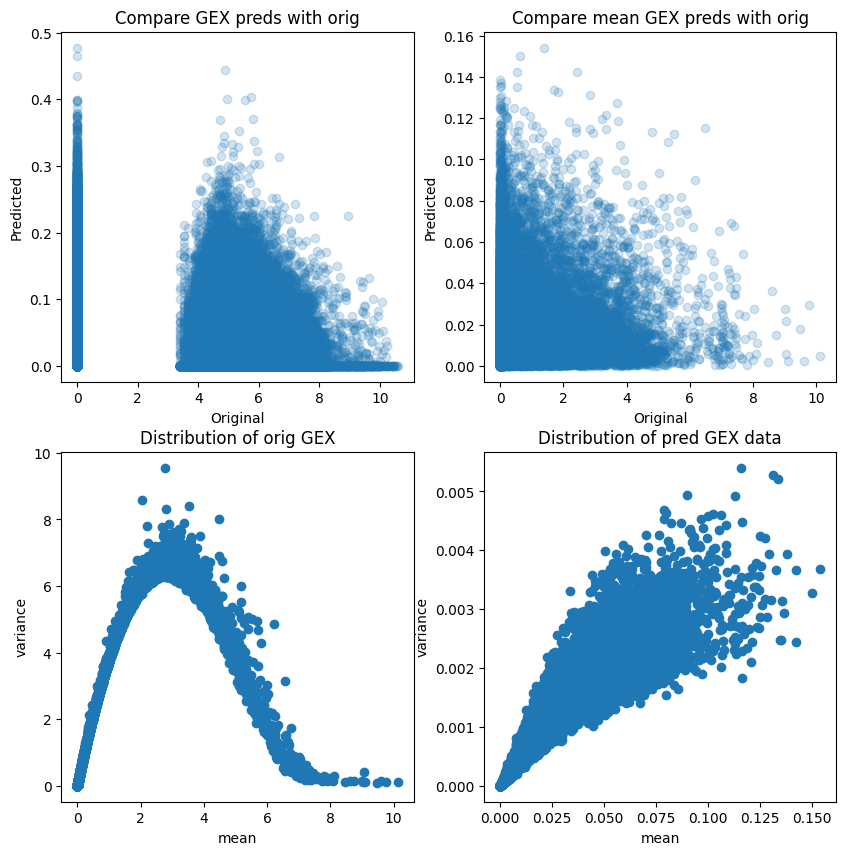

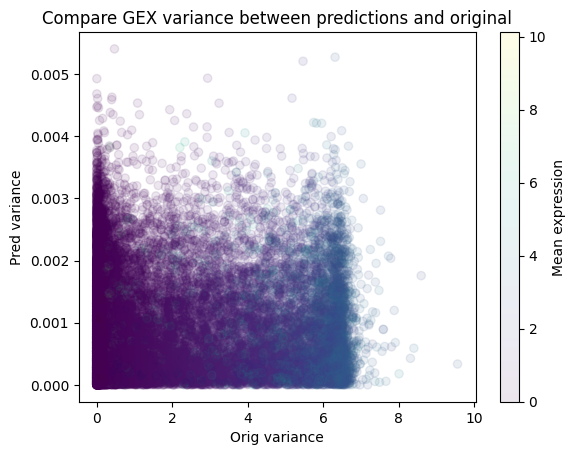

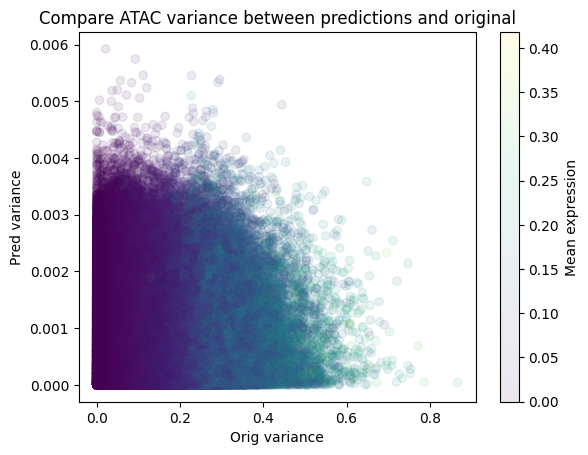

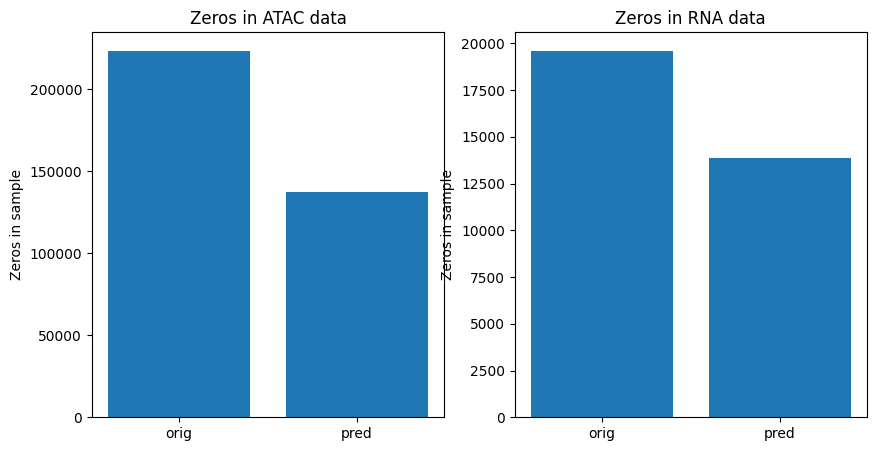

In [27]:
atac_pred, rna_pred, atac_orig, rna_orig = trainer.analyze_model(AE)
plot_model_analysis(atac_pred, rna_pred, atac_orig, rna_orig)


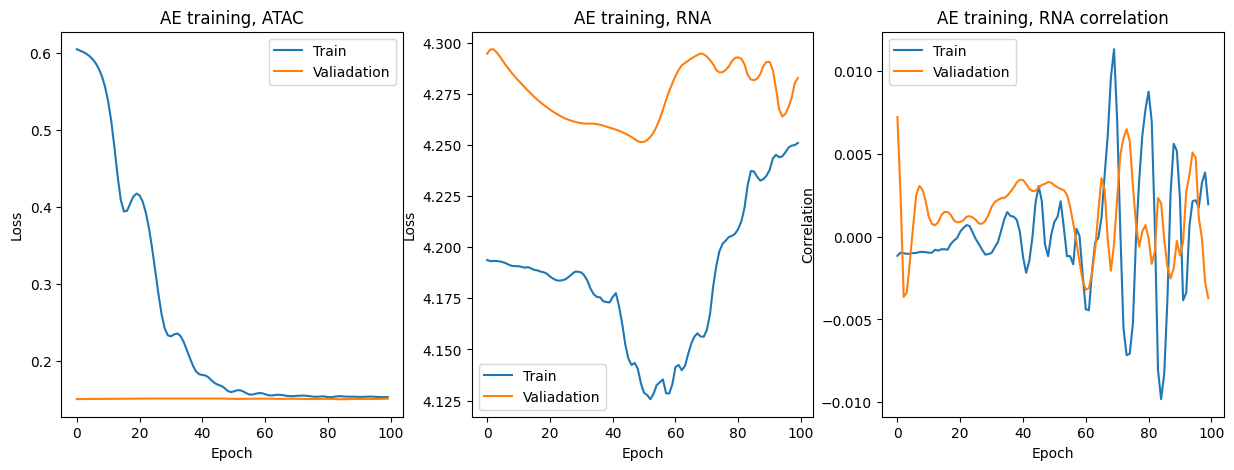

In [28]:
plot_progress(trainer)